In [1]:
import sys

import numpy as np
from importlib import reload

from astropy import units as u
from astropy import constants as cnst
from astropy import table
from astropy import modeling
from astropy.coordinates import (SkyCoord, Distance, 
                                 SphericalRepresentation, 
                                 CylindricalRepresentation)

from astropy.visualization import hist as ahist

import data_loaders

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams, style
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']

* Need to get Ting a dwarf LF/distance
* Need to compute size distributions to determine fiber sep (Connie sez 5" reasonable on Keck)

# Load the things

In [3]:
elvii_pairs = data_loaders.load_elvii_z0()

Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/lsst_experiments/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/e

In [4]:
# this is from http://stev.oapd.inaf.it/cgi-bin/cmd, with the PARSEC 1.2S w/ Z= 0.000152, 
# log(age) = 9.7 to 10.13
isoc_tab = table.Table.read('LSSTbands_FeHm2_10ishGyr_parsec.isoc', 
                            format='ascii.commented_header', header_start=15)
print(len(isoc_tab))
print('[Fe/H]:', np.log10(np.unique(isoc_tab['Z']).view(np.ndarray)/.0152))
print(1e-9*10**np.unique(isoc_tab['log(age/yr)'])*u.Gyr)
isoc_tab[:5].show_in_notebook()

2408
[Fe/H]: [-2.]
[  5.01187234   5.62341325   6.30957344   7.07945784   7.94328235
   8.91250938  10.          11.22018454  12.58925412] Gyr


Z,log(age/yr),M_ini,M_act,logL/Lo,logTe,logG,mbol,u,g,r,i,z,Y,C/O,M_hec,period,pmode,logMdot,slope,int_IMF,stage
0.000152,9.7,0.0939592868,0.094,-3.0447,3.5143,5.4647,12.382,18.858,15.124,13.343,12.307,11.838,11.652,0.4787,0.0,0.0,1,-18.02,0.0,1.5095663071,1
0.000152,9.7,0.0969958082,0.097,-2.963,3.5251,5.4402,12.178,18.276,14.742,13.02,12.092,11.661,11.479,0.4787,0.0,0.0,1,-18.006,0.0,1.5405944586,1
0.000152,9.7,0.1079185754,0.1079,-2.6894,3.5614,5.3582,11.494,16.369,13.486,12.014,11.362,11.043,10.884,0.4787,0.0,0.0,1,-17.96,0.0,1.6447788477,1
0.000152,9.7,0.1193510219,0.1193,-2.5418,3.5757,5.3116,11.124,15.568,12.912,11.555,10.976,10.693,10.543,0.4787,0.0,0.0,1,-17.916,0.0,1.7425737381,1
0.000152,9.7,0.1279185712,0.1279,-2.4401,3.5856,5.2795,10.87,15.038,12.528,11.252,10.712,10.449,10.307,0.4787,0.0,0.0,1,-17.886,0.0,1.8095752001,1


# Output Mstar/distances for ELVII halos

## Make ELVII artificially-oriented LG where M31 is second host 

In [5]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

for cat in elvii_pairs.values():
    for i in (0, 1):
        data_loaders.add_oriented_radecs(cat, 0, 1, target_coord=m31)
        data_loaders.add_oriented_radecs(cat, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [6]:
lsstmaxdec = 0*u.deg

halonum = 0
for cat in elvii_pairs.values():
    halonum += 1
    for i in (0, 1):
        d = cat['host{}_dist'.format(i)]
        satish = d < (cat['Rvir'][i])
        inlsst = cat['host{}_lat'.format(i)]< lsstmaxdec
        
        dsub = d[inlsst&satish]
        Mstarsub = cat['Mstar_preferred'][inlsst&satish]
        
        tab = table.Table()
        tab['distance'] = dsub.to(u.kpc) 
        tab['Mstar'] = Mstarsub
        
        print(len(tab))
        
        tab.write('mwish_{}.ecsv'.format(halonum), format='ascii.ecsv')

fns = !ls mwish_*.ecsv
fnss = ' '.join(fns)
!tar czf mwish_tabs.tar.gz $fnss
!rm $fnss

522
241
302
321
324
362
466
196
234
177
438
341
213
463
263
485
224
189
492
272
215
361
308
230


# Try to figure out fiber size

## Size scaling relations 

In [7]:
ntab = table.Table.read('NearbyGalaxies.dat',
                        header_start=28, data_start=35, 
                        format='ascii.fixed_width', delimiter=' ')
print(len(ntab))
ntab[:5].show_in_notebook()

97


GalaxyName,RA,Dec,EB-V,(m-M)o,vh(km/s),Vmag,PA,e=1-b/a,muVo,rh(arcmins),sigma_s(km/s),vrot_s(km/s),MHI,sigma_g(km/s),vrot_g(km/s),[Fe/H],F,References
Bootes II,13,12,0.03,18.1,-117.0,15.4,14,0.21 0.,28.1,4.20 1.4,10.5 7.4 7.,99.9 99.9 99,0.0,00.0 00.0 00.,00.0 00.0 0,-1.79,3,(9)(10)(98
Segue II,2,20,0.18,17.7,-39.2,15.2,18,0.15 0.,27.4,3.40 0.2,3.4 2.5 1.,99.9 99.9 99,99.0,99.9 99.9 99.,999.9 99.9 9,-2.0,1,(11)
Willman 1,10,51,0.01,17.9,-12.3,15.2,7,0.47 0.,26.1,2.30 0.4,4.3 2.3 1.,99.9 99.9 99,0.0,00.0 00.0 00.,00.0 00.0 0,-2.1,2,(12)(13)(9
Coma Beren,12,23,0.01,18.2,98.1,14.1,11,0.38 0.,27.3,6.00 0.6,4.6 0.8 0.,00.0 00.0 00,0.0,00.0 00.0 00.,00.0 00.0 0,-2.6,2,(5)(8)(98)
Bootes III,13,26,0.02,18.35,197.5,12.6,9,0.50 9.,31.3,99.99 9.9,14.0 3.2 3.,99.9 99.9 99,99.0,99.9 99.9 99.,999.9 99.9 9,-2.1,2,(14)(15)(9


(1, 3)

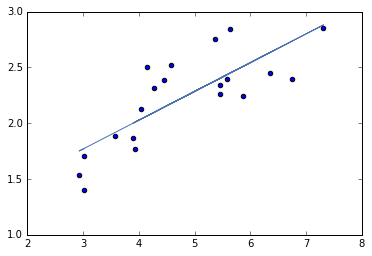

In [8]:
rh = np.array([float(s.split()[0]) for s in ntab['rh(arcmins)']])*u.arcmin
d = Distance(distmod=ntab['(m-M)o'])
Vabs = (ntab['Vmag']-ntab['(m-M)o'])*u.mag
lMstar = (Vabs.value-4.83)/-2.5

rp = (rh.to(u.radian).value*d).to(u.pc)

dmsk = (d<300*u.kpc)&(rp<1*u.kpc)
x = lMstar[dmsk]
y = np.log10(rp[dmsk]/u.pc)

lm = modeling.fitting.LinearLSQFitter()(modeling.models.Linear1D(), x, y)
plt.scatter(x, y)
plt.plot(x, lm(x))

mstar_to_rphys = lambda ms: u.pc*10**lm(np.log10(ms/u.solMass))

plt.xlim(2, 8)
plt.ylim(1, 3)

## Now make some realizations of ELVIS-like dwarfs

(15, -5)

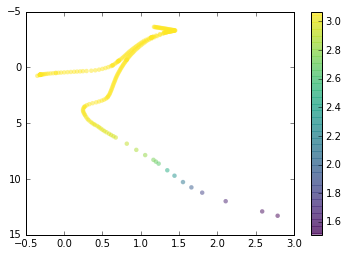

In [9]:
#scope out the isochrones
oldest_isoc = isoc_tab[isoc_tab['log(age/yr)']==10.1]
plt.scatter(oldest_isoc['g'] - oldest_isoc['i'], oldest_isoc['r'],
            c=oldest_isoc['int_IMF'], cmap='viridis', alpha=.5, lw=0)
plt.colorbar()
plt.xlim(-.5, 3)
plt.ylim(15, -5)

In [10]:
def get_isochrone_sampler(totmass, isoc=oldest_isoc):
    rescaled_int_IMF = isoc['int_IMF']-np.min(isoc['int_IMF'])
    rescaled_int_IMF /= np.ptp(isoc['int_IMF'])
    
    n_try = 3 * totmass / np.mean(isoc['M_ini']*u.solMass)
    sample0 = np.interp(np.random.rand(n_try), rescaled_int_IMF, 
                       np.arange(len(rescaled_int_IMF)))
    get_col0 = lambda col: np.interp(sample0, np.arange(len(rescaled_int_IMF)),
                                    isoc[col])
    sample = sample0[np.cumsum(get_col0('M_ini'))*u.solMass<=totmass]
    return lambda col: np.interp(sample, np.arange(len(rescaled_int_IMF)),
                                    isoc[col])

In [11]:
def sample_from_plummer(n, rhalf):
    #3D sampling
    lon = np.random.uniform(0, 2*np.pi,n)*u.radian
    lat = np.arcsin(np.random.uniform(-1,1, n))*u.radian
    r = rhalf / np.sqrt(np.random.uniform(0, 1, n)**(-2.0 / 3.0) - 1)
    
    sph = SphericalRepresentation(lon, lat, r)
    cyl = sph.represent_as(CylindricalRepresentation)
    return cyl.rho, cyl.phi

In [82]:
nper = 15
maxM = 1e6*u.solMass

dists = []
reffs = []
Msuns = []

for pairs in elvii_pairs.values():
    for i in (0, 1):
        tosample = pairs[pairs['host{}_dist'.format(i)] < pairs[i]['Rvir']]
        tosample = tosample[tosample['Mstar_preferred']<maxM]
        sample = tosample[np.random.permutation(len(tosample))[:nper]]
        dists.extend(sample['host{}_dist'.format(i)])
        Msuns.extend(sample['Mstar_preferred'])
        reffs.extend(mstar_to_rphys(sample['Mstar_preferred']))
        
dists = u.Quantity(dists)
reffs = u.Quantity(reffs)
Msuns = u.Quantity(Msuns)

In [83]:
faintesttargs = 22.5*u.mag

dwarfstar_tabs = []
for d, re, M in zip(dists, reffs, Msuns):
    isamp = get_isochrone_sampler(M)
    r = isamp('r')*u.mag + Distance(d).distmod
    targs = r < faintesttargs
    rho, phi = sample_from_plummer(np.sum(targs), re)
    
    tab = table.Table()
    tab['rad_phys'] = rho
    tab['rad_sky'] = (rho/d).decompose()*u.radian
    tab['phi'] = phi
    tab['r_app'] = r[targs]
    dwarfstar_tabs.append(tab)
    

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [84]:
# show the FOVs
seps = []
for tab in dwarfstar_tabs:
    x = tab['rad_sky'] * np.cos(tab['phi'])
    y = tab['rad_sky'] * np.sin(tab['phi'])
    if len(tab)>1:
        sc = SkyCoord(x, y)
        _, closest, _ = sc.match_to_catalog_sky(sc, 2)
        seps.append(closest)
    else:
        seps.append(None)
allseps = [s.to(u.arcsec).value for s in seps if s is not None]
allseps = np.concatenate(allseps)*u.arcsec

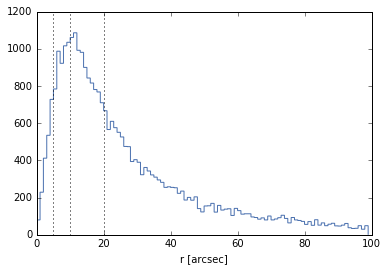

In [85]:
ahist(allseps, range(0, 100), histtype='step')
plt.axvline(5,c='k', ls=':')
plt.axvline(10,c='k', ls=':')
plt.axvline(20,c='k', ls=':')
plt.xlabel('r [arcsec]')

In [97]:
maxM = 1e6*u.solMass
minM = 1e3*u.solMass

dists = []
reffs = []
Msuns = []

for pairs in elvii_pairs.values():
    for i in (0, 1):
        tosample = pairs[pairs['host{}_dist'.format(i)] < pairs[i]['Rvir']]
        sizemsk = (tosample['Mstar_preferred']>minM)&(tosample['Mstar_preferred']<maxM)
        tosample = tosample[sizemsk]
        sample = tosample[np.random.permutation(len(tosample))]
        dists.extend(sample['host{}_dist'.format(i)])
        Msuns.extend(sample['Mstar_preferred'])
        reffs.extend(mstar_to_rphys(sample['Mstar_preferred']))
        
dists = u.Quantity(dists)
reffs = u.Quantity(reffs)
Msuns = u.Quantity(Msuns)

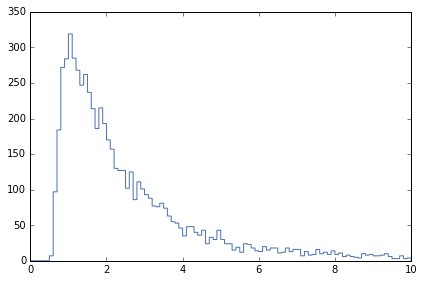

In [98]:
rsky = (reffs/dists).decompose()*u.radian

ahist(rsky.to(u.arcmin), histtype='step',range=(0,10), bins=100)
plt.tight_layout()